# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

## Imports

In [54]:
!pip install onnx onnxruntime
!pip install onnx onnxscript onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 17.2 MB/s eta 0:00:00


In [28]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import onnx
import onnxruntime as ort
import helper_utils

## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

data_dir = path
train_dir = os.path.join(data_dir, 'seg_train/seg_train')
test_dir = os.path.join(data_dir, 'seg_test/seg_test')

print(f"\nTrain directory: {train_dir}")
print(f"Test directory: {test_dir}")

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification

Train directory: /kaggle/input/intel-image-classification/seg_train/seg_train
Test directory: /kaggle/input/intel-image-classification/seg_test/seg_test


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [6]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

train_dataset = datasets.ImageFolder(train_dir, transform=simple_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=simple_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of classes: 6


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [7]:
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print("\nSamples per class (Training):")
for i, class_name in enumerate(class_names):
    count = sum(1 for _, label in train_dataset if label == i)
    print(f"  {class_name}: {count}")

Training samples: 14034
Test samples: 3000

Samples per class (Training):
  buildings: 2191
  forest: 2271
  glacier: 2404
  mountain: 2512
  sea: 2274
  street: 2382


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),}

In [9]:
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(test_dir, data_transforms['val'])}


batch_size = 32
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size,
                       shuffle=True, num_workers=2, pin_memory=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size,
                     shuffle=False, num_workers=2, pin_memory=True)}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print(f"Dataset sizes: {dataset_sizes}")
print(f"Batch size: {batch_size}")
print(f"Batches per epoch: Train={len(dataloaders['train'])}, Val={len(dataloaders['val'])}")

Dataset sizes: {'train': 14034, 'val': 3000}
Batch size: 32
Batches per epoch: Train=439, Val=94


**Quick Check**: Visualize a batch of training images

In [30]:
helper_utils.visualize_batch?

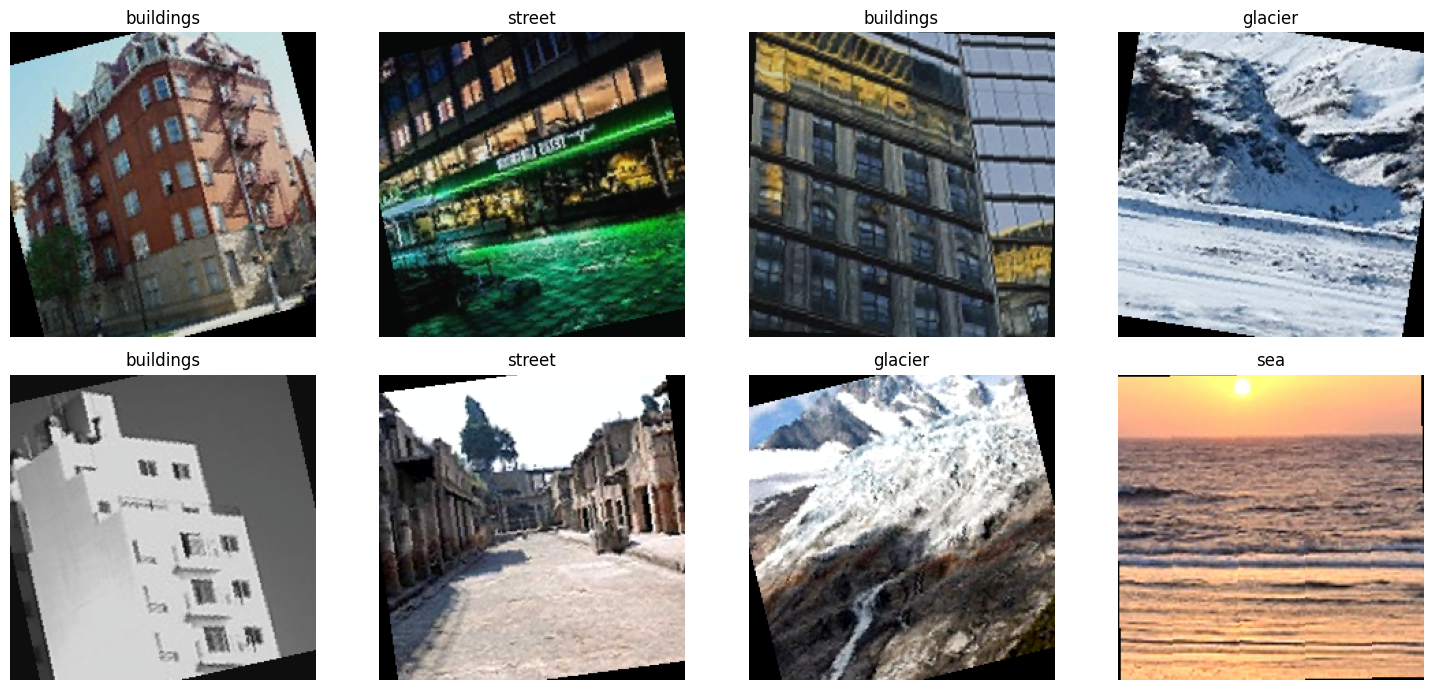

In [11]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

inputs, classes = next(iter(dataloaders['train']))

fig, axes = plt.subplots(2, 4, figsize=(15, 7))
axes = axes.flatten()
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(inputs[i], title=class_names[classes[i]])

plt.tight_layout()
plt.show()

<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [12]:
def create_resnet18_model(num_classes=6, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [39]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase], desc=f'{phase.capitalize():5}')
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                pbar.set_postfix({
                    'loss': loss.item(),
                    'acc': running_corrects.double() / ((pbar.n + 1) * inputs.size(0))
                })
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize():5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [40]:
model_conv = create_resnet18_model(num_classes=num_classes, pretrained=True)
model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = False

for param in model_conv.fc.parameters():
    param.requires_grad = True

print("\nTrainable parameters:")
trainable_params = sum(p.numel() for p in model_conv.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_conv.parameters())
print(f"  Trainable: {trainable_params:,}")
print(f"  Total: {total_params:,}")
print(f"  Percentage: {100 * trainable_params / total_params:.2f}%")


Trainable parameters:
  Trainable: 3,078
  Total: 11,179,590
  Percentage: 0.03%


In [41]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [43]:
model_conv, history_conv = train_model(
    model_conv,
    criterion,
    optimizer_conv,
    exp_lr_scheduler,
    num_epochs=10)


Epoch 1/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:00<00:00,  7.21it/s, loss=0.681, acc=tensor(1.3938, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.6566 Acc: 0.7830


Val  : 100%|██████████| 94/94 [00:08<00:00, 10.50it/s, loss=0.297, acc=tensor(1.1738, device='cuda:0', dtype=torch.float64)]


Val   Loss: 0.3727 Acc: 0.8827

Epoch 2/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [00:59<00:00,  7.33it/s, loss=0.407, acc=tensor(1.5301, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.4108 Acc: 0.8596


Val  : 100%|██████████| 94/94 [00:08<00:00, 10.82it/s, loss=0.388, acc=tensor(1.1822, device='cuda:0', dtype=torch.float64)]


Val   Loss: 0.3296 Acc: 0.8890

Epoch 3/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:02<00:00,  7.06it/s, loss=0.409, acc=tensor(1.5450, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.3834 Acc: 0.8680


Val  : 100%|██████████| 94/94 [00:08<00:00, 10.51it/s, loss=0.359, acc=tensor(1.1857, device='cuda:0', dtype=torch.float64)]


Val   Loss: 0.3065 Acc: 0.8917

Epoch 4/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:00<00:00,  7.22it/s, loss=0.237, acc=tensor(1.5463, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.3695 Acc: 0.8687


Val  : 100%|██████████| 94/94 [00:08<00:00, 11.16it/s, loss=0.364, acc=tensor(1.1910, device='cuda:0', dtype=torch.float64)]


Val   Loss: 0.2993 Acc: 0.8957

Epoch 5/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:00<00:00,  7.27it/s, loss=0.197, acc=tensor(1.5530, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.3529 Acc: 0.8744


Val  : 100%|██████████| 94/94 [00:09<00:00, 10.16it/s, loss=0.248, acc=tensor(1.1968, device='cuda:0', dtype=torch.float64)]


Val   Loss: 0.2840 Acc: 0.9000

Epoch 6/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:00<00:00,  7.24it/s, loss=0.147, acc=tensor(1.5587, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.3522 Acc: 0.8757


Val  : 100%|██████████| 94/94 [00:08<00:00, 10.54it/s, loss=0.248, acc=tensor(1.1959, device='cuda:0', dtype=torch.float64)]


Val   Loss: 0.2812 Acc: 0.8993

Epoch 7/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:00<00:00,  7.20it/s, loss=0.434, acc=tensor(1.5543, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.3480 Acc: 0.8752


Val  : 100%|██████████| 94/94 [00:08<00:00, 11.60it/s, loss=0.316, acc=tensor(1.1941, device='cuda:0', dtype=torch.float64)]


Val   Loss: 0.2833 Acc: 0.8980

Epoch 8/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:00<00:00,  7.25it/s, loss=0.149, acc=tensor(1.5630, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.3397 Acc: 0.8781


Val  : 100%|██████████| 94/94 [00:09<00:00, 10.37it/s, loss=0.282, acc=tensor(1.2065, device='cuda:0', dtype=torch.float64)]


Val   Loss: 0.2823 Acc: 0.8977

Epoch 9/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:00<00:00,  7.31it/s, loss=0.114, acc=tensor(1.5667, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.3362 Acc: 0.8801


Val  : 100%|██████████| 94/94 [00:08<00:00, 11.49it/s, loss=0.265, acc=tensor(1.1950, device='cuda:0', dtype=torch.float64)]


Val   Loss: 0.2780 Acc: 0.8987

Epoch 10/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:00<00:00,  7.20it/s, loss=0.813, acc=tensor(1.5738, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.3328 Acc: 0.8841


Val  : 100%|██████████| 94/94 [00:09<00:00, 10.32it/s, loss=0.314, acc=tensor(1.1906, device='cuda:0', dtype=torch.float64)]

Val   Loss: 0.2859 Acc: 0.8953

Training complete in 11m 35s
Best val Acc: 0.0000


In [ ]:
# YOUR CODE HERE

**Quick Check**: Visualize training history

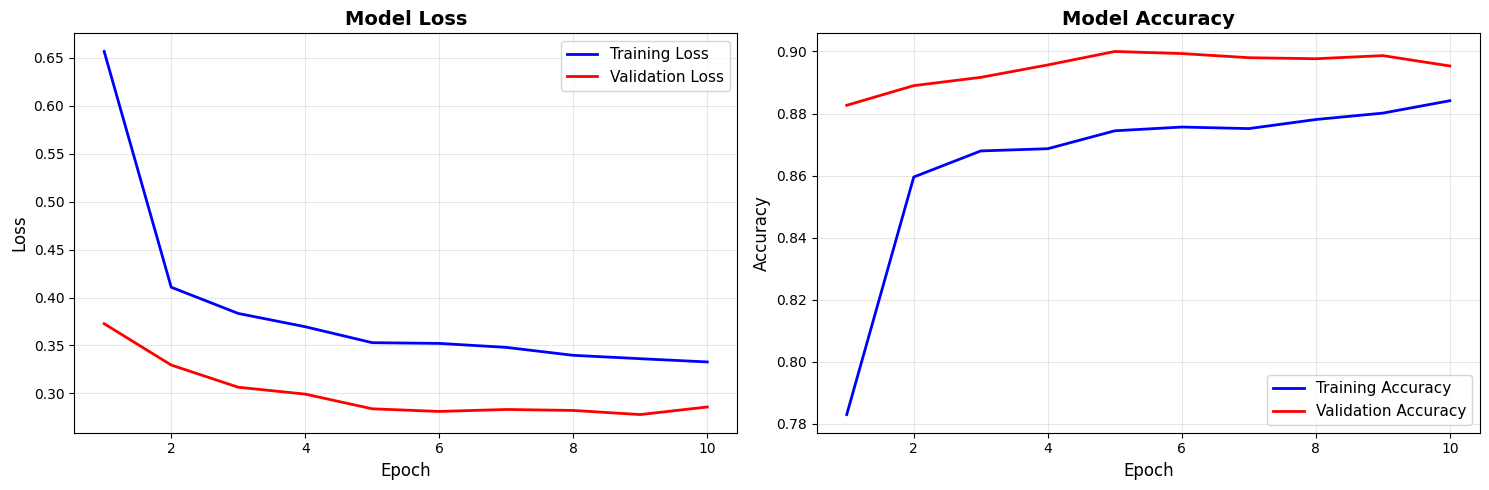

In [44]:
helper_utils.visualize_training_history(history_conv)
plt.show()

**Quick Check**: Visualize predictions

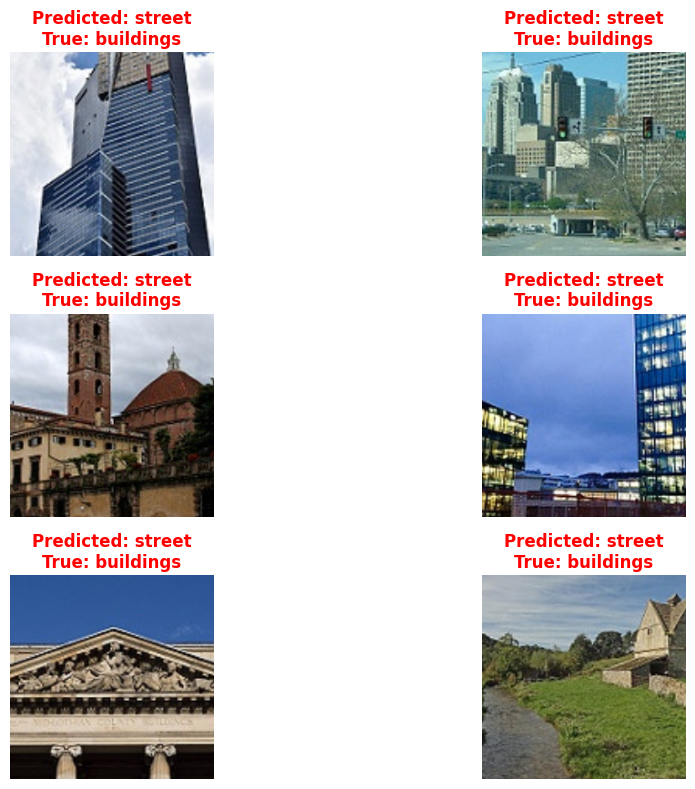

In [45]:
 helper_utils.visualize_predictions(model_conv, dataloaders['val'], class_names, device, num_images=6)
 plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [46]:
model_ft = create_resnet18_model(num_classes=num_classes, pretrained=True)
model_ft = model_ft.to(device)

print("\nTrainable parameters:")
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_ft.parameters())
print(f"  Trainable: {trainable_params:,}")
print(f"  Total: {total_params:,}")
print(f"  Percentage: {100 * trainable_params / total_params:.2f}%")


Trainable parameters:
  Trainable: 11,179,590
  Total: 11,179,590
  Percentage: 100.00%


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [47]:
print("TRAINING: FINE-TUNING APPROACH")
model_ft, history_ft = train_model(
    model_ft,
    criterion,
    optimizer_ft,
    exp_lr_scheduler_ft,
    num_epochs=10)

TRAINING: FINE-TUNING APPROACH

Epoch 1/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:10<00:00,  6.25it/s, loss=2.34, acc=tensor(0.2907, device='cuda:0', dtype=torch.float64)]


Train Loss: 2.1330 Acc: 0.1637


Val  : 100%|██████████| 94/94 [00:08<00:00, 10.73it/s, loss=2.24, acc=tensor(0.2325, device='cuda:0', dtype=torch.float64)]


Val   Loss: 2.2486 Acc: 0.1730

Epoch 2/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:08<00:00,  6.39it/s, loss=2.15, acc=tensor(0.2976, device='cuda:0', dtype=torch.float64)]


Train Loss: 2.1314 Acc: 0.1672


Val  : 100%|██████████| 94/94 [00:08<00:00, 10.51it/s, loss=2.26, acc=tensor(0.2301, device='cuda:0', dtype=torch.float64)]


Val   Loss: 2.2627 Acc: 0.1730

Epoch 3/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:09<00:00,  6.31it/s, loss=2.37, acc=tensor(0.2896, device='cuda:0', dtype=torch.float64)]


Train Loss: 2.1315 Acc: 0.1627


Val  : 100%|██████████| 94/94 [00:08<00:00, 11.23it/s, loss=2.22, acc=tensor(0.2336, device='cuda:0', dtype=torch.float64)]


Val   Loss: 2.2409 Acc: 0.1757

Epoch 4/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:09<00:00,  6.28it/s, loss=1.8, acc=tensor(0.2949, device='cuda:0', dtype=torch.float64)]


Train Loss: 2.1307 Acc: 0.1660


Val  : 100%|██████████| 94/94 [00:08<00:00, 11.49it/s, loss=2.22, acc=tensor(0.2314, device='cuda:0', dtype=torch.float64)]


Val   Loss: 2.2503 Acc: 0.1740

Epoch 5/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:09<00:00,  6.32it/s, loss=2.32, acc=tensor(0.2889, device='cuda:0', dtype=torch.float64)]


Train Loss: 2.1330 Acc: 0.1627


Val  : 100%|██████████| 94/94 [00:08<00:00, 10.47it/s, loss=2.26, acc=tensor(0.2318, device='cuda:0', dtype=torch.float64)]


Val   Loss: 2.2534 Acc: 0.1743

Epoch 6/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:09<00:00,  6.36it/s, loss=2.39, acc=tensor(0.2925, device='cuda:0', dtype=torch.float64)]


Train Loss: 2.1342 Acc: 0.1647


Val  : 100%|██████████| 94/94 [00:08<00:00, 10.56it/s, loss=2.24, acc=tensor(0.2327, device='cuda:0', dtype=torch.float64)]


Val   Loss: 2.2553 Acc: 0.1750

Epoch 7/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:08<00:00,  6.36it/s, loss=1.83, acc=tensor(0.2950, device='cuda:0', dtype=torch.float64)]


Train Loss: 2.1320 Acc: 0.1657


Val  : 100%|██████████| 94/94 [00:08<00:00, 11.11it/s, loss=2.24, acc=tensor(0.2371, device='cuda:0', dtype=torch.float64)]


Val   Loss: 2.2409 Acc: 0.1783

Epoch 8/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:08<00:00,  6.37it/s, loss=2.06, acc=tensor(0.2906, device='cuda:0', dtype=torch.float64)]


Train Loss: 2.1335 Acc: 0.1632


Val  : 100%|██████████| 94/94 [00:07<00:00, 12.08it/s, loss=2.26, acc=tensor(0.2278, device='cuda:0', dtype=torch.float64)]


Val   Loss: 2.2634 Acc: 0.1713

Epoch 9/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:09<00:00,  6.33it/s, loss=2.34, acc=tensor(0.2963, device='cuda:0', dtype=torch.float64)]


Train Loss: 2.1340 Acc: 0.1665


Val  : 100%|██████████| 94/94 [00:08<00:00, 10.66it/s, loss=2.19, acc=tensor(0.2327, device='cuda:0', dtype=torch.float64)]


Val   Loss: 2.2313 Acc: 0.1750

Epoch 10/10
------------------------------------------------------------


Train: 100%|██████████| 439/439 [01:08<00:00,  6.40it/s, loss=2.19, acc=tensor(0.2959, device='cuda:0', dtype=torch.float64)]


Train Loss: 2.1322 Acc: 0.1666


Val  : 100%|██████████| 94/94 [00:08<00:00, 10.50it/s, loss=2.25, acc=tensor(0.2278, device='cuda:0', dtype=torch.float64)]

Val   Loss: 2.2354 Acc: 0.1713

Training complete in 12m 59s
Best val Acc: 0.0000


In [ ]:
# YOUR CODE HERE

**Quick Check**: Visualize training history

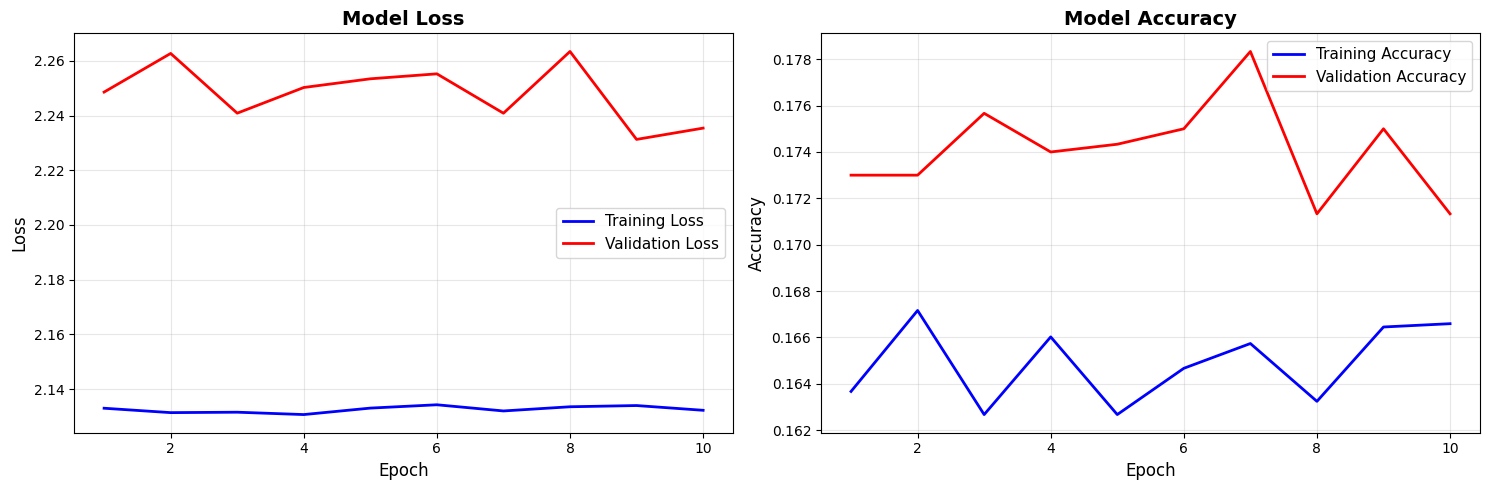

In [48]:
helper_utils.visualize_training_history(history_ft)
plt.show()

**Quick Check**: Visualize predictions

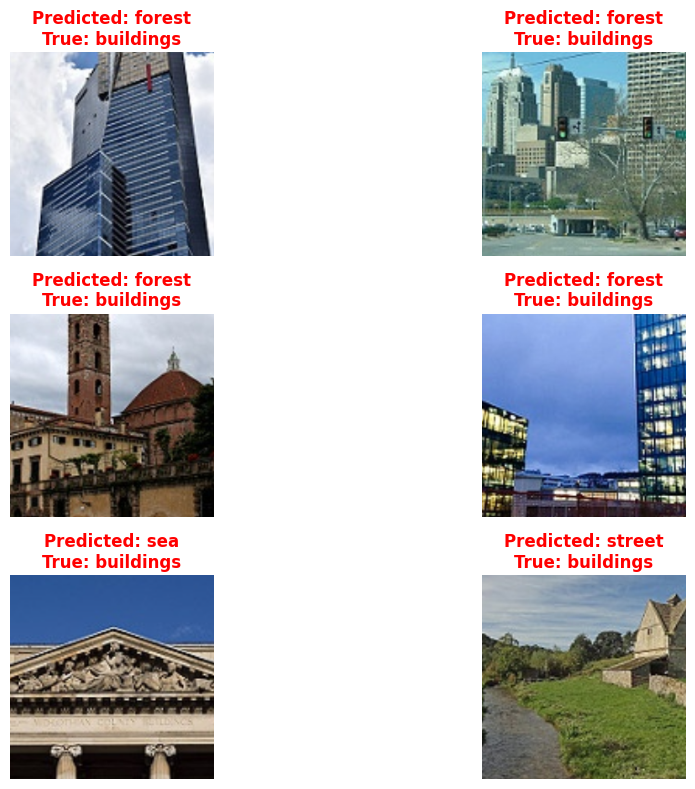

In [49]:
helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [50]:
print("MODEL COMPARISON")
print("\n1. Feature Extractor Approach:")
print(f"Best Val Accuracy: {max(history_conv['val_acc']):.4f} ({max(history_conv['val_acc'])*100:.2f}%)")
print(f"Final Val Accuracy: {history_conv['val_acc'][-1]:.4f} ({history_conv['val_acc'][-1]*100:.2f}%)")
print(f"Trainable Parameters: {sum(p.numel() for p in model_conv.fc.parameters()):,}")

print("\n2. Fine-tuning Approach:")
print(f"Best Val Accuracy: {max(history_ft['val_acc']):.4f} ({max(history_ft['val_acc'])*100:.2f}%)")
print(f"Final Val Accuracy: {history_ft['val_acc'][-1]:.4f} ({history_ft['val_acc'][-1]*100:.2f}%)")
print(f"Trainable Parameters: {sum(p.numel() for p in model_ft.parameters() if p.requires_grad):,}")

if max(history_ft['val_acc']) > max(history_conv['val_acc']):
    improvement = (max(history_ft['val_acc']) - max(history_conv['val_acc'])) * 100
    print(f"Fine-tuning is BETTER by {improvement:.2f}%")
else:
    improvement = (max(history_conv['val_acc']) - max(history_ft['val_acc'])) * 100
    print(f"Feature Extraction is BETTER by {improvement:.2f}%")

MODEL COMPARISON

1. Feature Extractor Approach:
Best Val Accuracy: 0.9000 (90.00%)
Final Val Accuracy: 0.8953 (89.53%)
Trainable Parameters: 3,078

2. Fine-tuning Approach:
Best Val Accuracy: 0.1783 (17.83%)
Final Val Accuracy: 0.1713 (17.13%)
Trainable Parameters: 11,179,590
Feature Extraction is BETTER by 72.17%


<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

Testing on: /kaggle/input/intel-image-classification/seg_test/seg_test/glacier/23219.jpg

Top 3 Predictions:
1. sea: 28.35%
2. forest: 25.51%
3. buildings: 16.77%


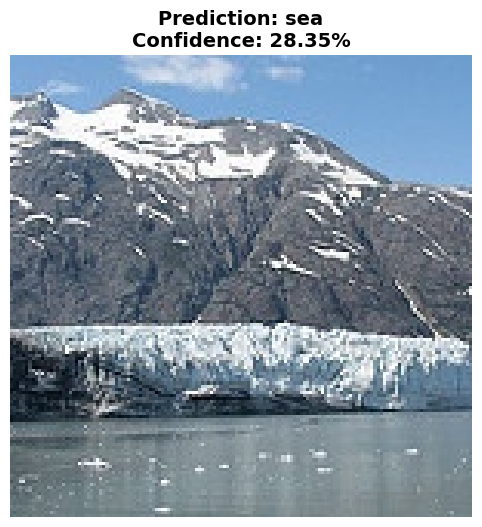

In [51]:
def predict_image(model, image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = data_transforms['val'](img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, pred_idx = torch.max(probs, 1)


    pred_class = class_names[pred_idx.item()]
    confidence = confidence.item()

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f'Prediction: {pred_class}\nConfidence: {confidence*100:.2f}%',
              fontsize=14, fontweight='bold')
    plt.axis('off')


    top3_probs, top3_idx = torch.topk(probs[0], 3)
    print("\nTop 3 Predictions:")
    for i, (prob, idx) in enumerate(zip(top3_probs, top3_idx), 1):
        print(f"{i}. {class_names[idx]}: {prob.item()*100:.2f}%")

    plt.show()
    return pred_class, confidence


import random
test_idx = random.randint(0, len(test_dataset)-1)
test_img_path = test_dataset.samples[test_idx][0]

print(f"Testing on: {test_img_path}")
pred_class, confidence = predict_image(model_ft, test_img_path)

# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [55]:
model_ft.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)
onnx_path = 'intel_classifier_resnet18.onnx'
torch.onnx.export(
    model_ft,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}})

/tmp/ipython-input-3559569797.py:5: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0110 12:28:19.829000 332 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[s77,3,224,224]>
            ),
            outputs=(
                %"output"<FLOAT,[1,6]>
            ),
            initializers=(
                %"fc.bias"<FLOAT,[6]>{TorchTensor<FLOAT,[6]>(Parameter containing: tensor([ 0.0399, -0.0015, -0.0372,  0.0104,  0.0243,  0.0326], device='cuda:0', requires_grad=True), name='fc.bias')},
                %"conv1.weight"<FLOAT,[64,3,7,7]>{Tensor(...)},
                %"layer1.0.conv1.weight"<FLOAT,[64,64,3,3]>{Tensor(...)},
                %"layer1.0.conv2.weight"<FLOAT,[64,64,3,3]>{Tensor(...)},
                %"layer1.1.conv1.weight"<FLOAT,[64,64,3,3]>{Tensor(...)},
                %"layer1.1.conv2.wei

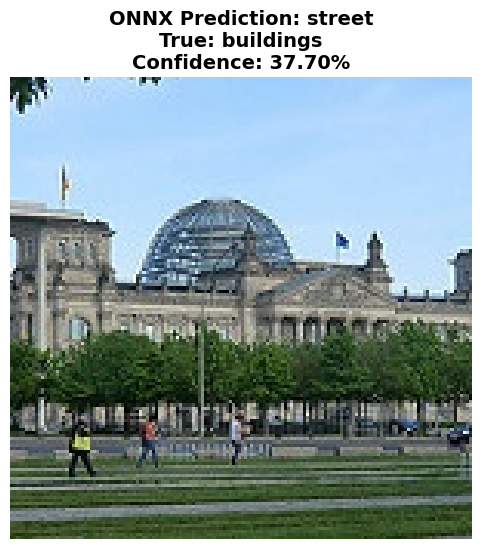


ONNX Model Inference:
True Label: buildings
Predicted: street
Confidence: 37.70%

✓ ONNX inference successful!


In [56]:
ort_session = ort.InferenceSession(onnx_path)

test_idx = random.randint(0, len(test_dataset)-1)
test_img_path = test_dataset.samples[test_idx][0]
true_label = class_names[test_dataset.samples[test_idx][1]]

img = Image.open(test_img_path).convert('RGB')
img_tensor = data_transforms['val'](img).unsqueeze(0)
img_numpy = img_tensor.numpy()

outputs = ort_session.run(None, {'input': img_numpy})
predictions = np.array(outputs[0])

pred_class_idx = np.argmax(predictions[0])
pred_class = class_names[pred_class_idx]

probs = np.exp(predictions[0]) / np.sum(np.exp(predictions[0]))
confidence = probs[pred_class_idx]
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f'ONNX Prediction: {pred_class}\nTrue: {true_label}\nConfidence: {confidence*100:.2f}%',
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

print(f"\nONNX Model Inference:")
print(f"True Label: {true_label}")
print(f"Predicted: {pred_class}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"\n ONNX inference successful!")